# Imports et initialisations

In [ ]:
!pip install mlflow dagshub

In [ ]:
import mlflow
import dagshub

import time
import os
from google.colab import userdata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
import matplotlib.font_manager as fm


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import mlflow.sklearn
from mlflow.models import infer_signature
import mlflow.pyfunc

import spacy

In [ ]:
# Récupère automatiquement le secret
dagshub_token = userdata.get('DAGSHUB_TOKEN')

# Initialisation Dagshub
dagshub.auth.add_app_token(dagshub_token)

# Connecter MLflow à Dagshub
dagshub.init(repo_owner='fabiencappelli', repo_name='Projet_07', mlflow=True)

# Configure MLflow pour pointer vers Dagshub
mlflow.set_tracking_uri('https://dagshub.com/fabiencappelli/Projet_07.mlflow')

In [ ]:
font_path = os.path.expanduser("/content/drive/MyDrive/Colab Notebooks/fonts/Exo2-VariableFont_wght.ttf")  # Remplacez par le chemin exact
fm.fontManager.addfont(font_path)

# Définir la police globale avec le nom de la police
rcParams["font.family"] = "Exo 2"
# deux couleurs pertinentes pour aller avec la présentation
bleuclair = (0.15, 0.55, 0.82)
couleur_complementaire = (1 - bleuclair[0], 1 - bleuclair[1], 1 - bleuclair[2])
bleufonce = "#073642"

In [ ]:
imgPrezPath = '/content/drive/MyDrive/Colab Notebooks/Projet_07/presentationimg'

In [ ]:
csvPath = '/content/drive/MyDrive/Colab Notebooks/Projet_07/df_cleaned.csv'

In [ ]:
df_cleaned = pd.read_csv(csvPath, encoding='latin-1')

In [ ]:
# Division en jeu d'entraînement et de test
X = df_cleaned['text']
y = df_cleaned['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

# TF-IDF

Attention, contrairement à ce que j'ai fait dans le passé puisqu'on était dans du non supervisé ici étant dans du supervisé je dois faire attention à ce que mon TF-IDF n'ait pas de fuites de données. Donc l'intégrer dans le pipeline, et du coup aussi rechercher les meilleurs hyperparams pour TFIDF aussi dans la grid search

## Choix du solver

solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’

    Algorithm to use in the optimization problem. Default is ‘lbfgs’. To choose a solver, you might want to consider the following aspects:

        For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;

        For multiclass problems, all solvers except ‘liblinear’ minimize the full multinomial loss;

        ‘liblinear’ can only handle binary classification by default. To apply a one-versus-rest scheme for the multiclass setting one can wrap it with the OneVsRestClassifier.

        ‘newton-cholesky’ is a good choice for n_samples >> n_features * n_classes, especially with one-hot encoded categorical features with rare categories. Be aware that the memory usage of this solver has a quadratic dependency on n_features * n_classes because it explicitly computes the full Hessian matrix.
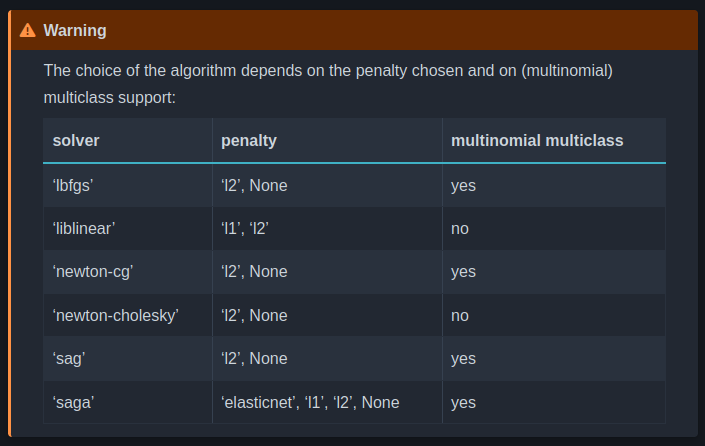

Mon ami ChatGPT

Il n'existe pas de seuil fixe et universel pour qualifier un dataset de "small" dans scikit-learn, car cela dépend beaucoup des ressources matérielles disponibles (mémoire, processeur) et du type de modèle utilisé. Cependant, on peut donner quelques repères généraux :

- **Petits datasets typiques :**  
  scikit-learn est conçu pour des datasets qui tiennent en mémoire, ce qui correspond souvent à quelques dizaines de milliers jusqu'à quelques centaines de milliers d'exemples. Dans de nombreux cas, c'est même quelques milliers d'exemples qui suffisent pour entraîner un modèle de manière efficace avec scikit-learn.

- **Cas extrêmes :**  
  Certains algorithmes de scikit-learn peuvent gérer quelques millions d'exemples, à condition que les données tiennent en mémoire et que le prétraitement soit adapté.  
  Pour des datasets bien plus volumineux (des dizaines de millions d'exemples ou plus), il devient souvent nécessaire de passer à des frameworks ou bibliothèques conçus pour le Big Data (comme Dask-ML, Spark MLlib, etc.).

En résumé, dans l'univers de scikit-learn, un "small dataset" est généralement celui qui peut être entièrement chargé dans la mémoire vive de ton système et traité avec des algorithmes qui ne nécessitent pas d'approches distribuées. Les repères habituels tournent souvent autour de quelques dizaines de milliers à quelques centaines de milliers d'exemples, selon la complexité des features et des modèles.

1,6 million d'exemples peut être considéré comme un dataset relativement volumineux pour scikit-learn, mais tout dépend :

- **Capacité mémoire :**  
  scikit-learn charge généralement l'ensemble du dataset en mémoire. Avec 1,6 million d'exemples, cela peut être assez lourd si le nombre de caractéristiques (features) est élevé. Toutefois, si tu utilises une représentation sparse (comme c'est souvent le cas avec TF-IDF), cela peut rester gérable, à condition d'avoir suffisamment de RAM.

- **Type de modèle et complexité :**  
  Pour des algorithmes comme la régression logistique ou des modèles linéaires, scikit-learn peut généralement traiter ce volume sur des machines modernes disposant de 16 Go de RAM ou plus. Si le modèle implique des algorithmes plus gourmands en ressources ou si tu utilises des pipelines complexes, tu pourrais rencontrer des lenteurs ou des limites mémoire.

- **Alternatives pour des datasets plus volumineux :**  
  Si 1,6 million d'exemples devient problématique, tu pourrais envisager :
  - Des techniques d'apprentissage incrémental (par exemple, `SGDClassifier` pour la régression logistique).
  - Des bibliothèques conçues pour le big data comme Dask-ML, qui permettent une gestion distribuée.

En résumé, 1,6 million d'exemples est à la limite supérieure du "small/moyen dataset" dans scikit-learn. Avec une bonne gestion de la mémoire (par exemple, utilisation de matrices creuses pour le TF-IDF), cela est tout à fait faisable sur des machines disposant de ressources suffisantes.

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(solver='liblinear'))
])

In [ ]:
# Définition de la grille d'hyperparamètres
param_grid = {
    'tfidf__min_df': [0.02, 0.05, 0.07, 0.1],
    'tfidf__max_df': [0.8, 0.9, 0.95, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'lr__C': [0.1, 1, 10]
}

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=1, scoring='accuracy')

mlflow.set_experiment("TFIDF_LogisticRegression_with_Metrics")

with mlflow.start_run():

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Mesurer le temps d'inférence sur le set de test
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    total_ms = (time.time() - start_time) * 1000
    inf_ms_per_sample = total_ms / len(X_test)

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Pour le ROC AUC, on utilise decision_function
    y_scores = best_model.decision_function(X_test)
    roc_auc = roc_auc_score(y_test, y_scores)

    # Log des paramètres et métriques dans MLflow
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_f1", f1)
    mlflow.log_metric("test_roc_auc", roc_auc)
    mlflow.log_metric("test_inference_time_ms_per_sample", inf_ms_per_sample)

    # Créer un exemple d'entrée. Ici, un échantillon du texte
    input_example = X_test.iloc[:5].tolist()

    # Produire des prédictions pour inférer la signature
    predictions = best_model.predict(input_example)

    # Inférer la signature du modèle
    signature = infer_signature(input_example, predictions)

    # Log le modèle de manière à pouvoir le rappeler
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="model",
        signature=signature,
        input_example=input_example,
        registered_model_name="MyModel"
    )

    print("Meilleurs paramètres :", grid_search.best_params_)
    print("Accuracy :", accuracy)
    print("F1-score :", f1)
    print("ROC AUC :", roc_auc)
    print("Temps d'inférence (millisecondes) :", inf_ms_per_sample)

## Lemmatization avec Spacy

In [ ]:
# Charger le modèle de spaCy
# en_core_web_sm, en_core_web_md, en_core_web_lg
nlp = spacy.load("en_core_web_sm")

def spacy_tokenizer(text):
    doc = nlp(text)
    # Conserver uniquement les tokens alphanumériques, en minuscules, lemmatisés, sans stopwords ni ponctuation
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Appliquer le prétraitement à la colonne 'document'
df_cleaned['document_clean'] = df_cleaned['text'].apply(spacy_tokenizer)

In [ ]:
# Division en jeu d'entraînement et de test
X = df_cleaned['document_clean']
y = df_cleaned['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=1, scoring='accuracy')

mlflow.set_experiment("TFIDF_LogisticRegression_with_Metrics_Spacy_Tokens")

with mlflow.start_run():

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Mesurer le temps d'inférence sur le set de test
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    total_ms = (time.time() - start_time) * 1000
    inf_ms_per_sample = total_ms / len(X_test)

    # Calcul des métriques
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Pour le ROC AUC, on utilise decision_function
    y_scores = best_model.decision_function(X_test)
    roc_auc = roc_auc_score(y_test, y_scores)

    # Log des paramètres et métriques dans MLflow
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_f1", f1)
    mlflow.log_metric("test_roc_auc", roc_auc)
    mlflow.log_metric("test_inference_time_ms_per_sample", inf_ms_per_sample)

    # Créer un exemple d'entrée. Ici, un échantillon du texte
    input_example = X_test.iloc[:5].tolist()

    # Produire des prédictions pour inférer la signature
    predictions = best_model.predict(input_example)

    # Inférer la signature du modèle
    signature = infer_signature(input_example, predictions)

    # Log le modèle de manière à pouvoir le rappeler
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="model",
        signature=signature,
        input_example=input_example,
        registered_model_name="MyModel"
    )

    print("Meilleurs paramètres :", grid_search.best_params_)
    print("Accuracy :", accuracy)
    print("F1-score :", f1)
    print("ROC AUC :", roc_auc)
    print("Temps d'inférence (millisecondes) :", inf_ms_per_sample)